In [ ]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import tifffile
from oasis.functions import deconvolve
from scipy.ndimage import median_filter
from scipy.optimize import curve_fit
from scipy.signal import find_peaks, savgol_filter
from scipy.stats import pearsonr
from tqdm import tqdm

from micromanager_gui.readers import TensorstoreZarrReader

In [252]:
R_SQUARE_THRESHOLD = 0.95

# path = "/Volumes/T7 Shield/neurons/SSADH_Fam005_CC240711_IG_NC_PlateC_240925_GCaMP6s/SSADH_Fam005_CC240711_IG_NC_PlateC_240925_GCaMP6s.tensorstore.zarr"
# label_path = "/Volumes/T7 Shield/neurons/SSADH_Fam005_CC240711_IG_NC_PlateC_240925_GCaMP6s/SSADH_Fam005_CC240711_IG_NC_PlateC_240925_GCaMP6s_labels"
path = "/Volumes/T7 Shield/neurons/NC240509_240523_Chronic/NC240509_240523_Chronic.tensorstore.zarr"
label_path = "/Volumes/T7 Shield/neurons/NC240509_240523_Chronic/NC240509_240523_Chronic_labels"

In [253]:
def single_exponential(x: np.ndarray, a: float, b: float, c: float) -> np.ndarray:
    return np.array(a * np.exp(-b * x) + c)


def get_exponential_decay(
    trace: np.ndarray,
) -> tuple[list[float], list[float], float] | None:
    """Fit an exponential decay to the trace.

    Returns None if the R squared value is less than 0.9.
    """
    time_points = np.arrange(len(trace))
    initial_guess = [max(trace), 0.01, min(trace)]
    try:
        popt, _ = curve_fit(
            single_exponential, time_points, trace, p0=initial_guess, maxfev=2000
        )
        fitted_curve = single_exponential(time_points, *popt)
        residuals = trace - fitted_curve
        r, _ = pearsonr(trace, fitted_curve)
        ss_total = np.sum((trace - np.mean(trace)) ** 2)
        ss_res = np.sum(residuals**2)
        r_squared = 1 - (ss_res / ss_total)
    except Exception as e:
        print("Error fitting curve: %s", e)
        return None

    return (
        None
        if r_squared <= R_SQUARE_THRESHOLD
        else (fitted_curve.tolist(), popt.tolist(), float(r_squared))
    )


def bi_exponential(
    x: np.ndarray, a1: float, b1: float, a2: float, b2: float, c: float
) -> np.ndarray:
    """Bi-exponential decay function."""
    return np.array(a1 * np.exp(-b1 * x) + a2 * np.exp(-b2 * x) + c)


def get_bi_exponential_decay(
    trace: np.ndarray,
) -> tuple[list[float], list[float], float] | None:
    """Fit a bi-exponential decay to the trace.

    Returns None if the R squared value is less than 0.96.
    """
    time_points = np.arrange(len(trace))
    scaled_time = time_points / np.max(time_points)  # Normalize `x` to [0, 1]

    # Initial guess for the parameters: [a1, b1, a2, b2, c]
    initial_guess = [max(trace) / 2, 1.0, max(trace) / 2, 1.0, min(trace)]
    bounds = (
        [0, 0, 0, 0, -np.inf],
        [np.inf, 10, np.inf, 10, np.inf],
    )  # Parameter bounds

    try:
        popt, _ = curve_fit(
            bi_exponential,
            scaled_time,
            trace,
            p0=initial_guess,
            bounds=bounds,
            maxfev=5000,
        )
        fitted_curve = bi_exponential(scaled_time, *popt)
        residuals = trace - fitted_curve
        ss_total = np.sum((trace - np.mean(trace)) ** 2)
        ss_res = np.sum(residuals**2)
        r_squared = 1 - (ss_res / ss_total)
    except Exception as e:
        print(f"Error fitting bi-exponential curve: {e}")
        return None

    # Return None if the R² is less than R_SQUARE_THRESHOLD
    if r_squared <= R_SQUARE_THRESHOLD:
        return None

    return fitted_curve.tolist(), popt.tolist(), r_squared

def correct_photobleaching(trace: np.ndarray, fitted_curve: np.ndarray, offset: list[float]) -> np.ndarray:
    """Correct for photobleaching using the fitted curve."""
    # Subtract the fitted curve to remove photobleaching
    corrected_trace = trace - fitted_curve + offset

    # Normalize the corrected signal to maintain meaningful scaling
    corrected_trace = corrected_trace / np.mean(corrected_trace) * np.mean(trace)

    return corrected_trace

def calculate_dff(pc_trace, window=100, plot: bool = False):
    dff = []
    bg, median = _calculate_bg(pc_trace, window)
    bg = list(bg)
    dff = (pc_trace - bg) / bg
    dff = dff - np.min(dff)

    # plot median and background
    if plot:
        plt.figure(figsize=(10, 8))
        plt.plot(median, label="median", color="green")
        plt.plot(bg, label="background", color="black")
        plt.plot(pc_trace, label="trace", color="blue")
        plt.legend()
        plt.show()

    return dff


# def _calculate_bg(f: np.ndarray, window: int):
#     background = np.zeros_like(f)
#     background[0] = f[0]
#     median = [background[0]]
#     for y in range(1, len(f)):
#         x = y - window
#         if x < 0:
#             x = 0
#         lower_quantile = f[x:y] <= np.median(f[x:y])
#         background[y] = np.mean(f[x:y][lower_quantile])
#         median.append(np.median(f[x:y]))
#     return background, median


def _calculate_bg(f: np.ndarray, window: int):
    # Compute the median using a median filter
    rolling_median = median_filter(f, size=window, mode='nearest')

    # Calculate background using the lower quantile mean
    background = []
    for y in range(len(f)):
        x = max(0, y - window // 2)
        lower_quantile = f[x:y+1][f[x:y+1] <= rolling_median[y]]
        background.append(np.mean(lower_quantile) if len(lower_quantile) > 0 else f[y])

    return np.array(background), rolling_median


def _find_peaks(trace: np.ndarray, prominence: float | None = None) -> list[int]:
    """Smooth the trace and find the peaks."""
    smoothed_normalized = _smooth_and_normalize(trace)
    # find the peaks # TODO: find the necessary parameters to use
    peaks, _ = find_peaks(smoothed_normalized, width=3, prominence=prominence)
    return peaks.tolist()


def _smooth_and_normalize(
    trace: np.ndarray, window_length: int = 5, polyorder: int = 2
) -> np.ndarray:
    """Smooth and normalize the trace between 0 and 1."""
    # smoothing that preserves the peaks
    smoothed = savgol_filter(trace, window_length=window_length, polyorder=polyorder)
    # normalize the smoothed trace from 0 to 1
    return (smoothed - np.min(smoothed)) / (np.max(smoothed) - np.min(smoothed))


def find_peaks1(spike_signal: np.ndarray, threshold: float | None = None) -> list[int]:
    """Find the peaks in the spike signal (S)."""
    if threshold is None:
        # Default threshold: e.g., consider spikes above 10% of the maximum value
        threshold = np.max(spike_signal) * 0.1

    # Find time points where the spike signal exceeds the threshold
    peaks = np.where(spike_signal > threshold)[0]

    # Ensure it's a list of integers
    return peaks.tolist()


def _get_amplitude(
    dff: list[float],
    peaks: list[int],
    deriv_threshold=0.01,
    reset_num=17,
    neg_reset_num=2,
    total_dist=40,
) -> tuple[list[float], list[int], list[int], list[int]]:
    """Calculate amplitudes, peak indices, and base indices of each ROI."""
    if not peaks:
        return [], [], [], []

    dff_deriv = np.diff(dff)
    len_dff_deriv = len(dff_deriv)

    def find_boundary(index, direction):
        """Find start or end boundary around a peak."""
        step = -1 if direction == "backward" else 1
        boundary = index
        under_thresh_count = total_count = 0

        while 0 <= boundary < len_dff_deriv and total_count < total_dist:
            boundary += step
            total_count += 1

            # Ensure boundary does not go out of bounds
            if boundary < 0 or boundary >= len_dff_deriv:
                break

            if boundary in peaks:  # Handle crossing other peaks
                neg_count = 0
                while 0 <= boundary < len_dff_deriv and neg_count < neg_reset_num:
                    if (
                        dff_deriv[boundary] * step < 0
                    ):  # Negative slope for backward, positive for forward
                        neg_count += 1
                    else:
                        neg_count = 0
                    boundary += step
                return boundary - step

            if abs(dff_deriv[boundary]) < deriv_threshold:
                under_thresh_count += 1
            else:
                under_thresh_count = 0

            if under_thresh_count >= reset_num:
                break

        return boundary

    amplitudes, start_indices, end_indices, valid_peaks = [], [], [], []

    for peak in peaks:
        start_index = find_boundary(peak, "backward")
        end_index = find_boundary(peak, "forward")

        # Ensure valid indices for slicing
        if start_index < 0:
            start_index = 0
        if end_index >= len(dff):
            end_index = len(dff) - 1

        # Slice and check for empty arrays
        start_to_peak = dff[start_index:peak]
        peak_to_end = dff[peak : end_index + 1]

        if len(start_to_peak) == 0 or len(peak_to_end) == 0:
            continue  # Skip this peak if slices are invalid

        # Calculate f_start_index, f_end_index, and amplitude
        f_start_index = start_index + np.argmin(start_to_peak)
        f_end_index = peak + np.argmin(peak_to_end)
        amplitude = dff[peak] - dff[f_start_index]

        if amplitude > 0:
            amplitudes.append(amplitude)
            start_indices.append(f_start_index)
            end_indices.append(f_end_index)
            valid_peaks.append(peak)

    return amplitudes, start_indices, end_indices, valid_peaks


def calculate_peak_amplitudes(trace: np.ndarray, peaks, peaks_props):
    """
    Calculate the amplitude of peaks in a signal relative to their baseline.

    Parameters
    ----------
        trace: The input signal (e.g., dff or d_dff).
        prominence: Minimum prominence of peaks.
        width: Minimum width of peaks.

    Returns
    -------
        peaks: Indices of the detected peaks.
        amplitudes: Amplitude of each peak relative to its baseline.
    """
    # Calculate baselines
    left_bases = peaks_props["left_bases"]
    right_bases = peaks_props["right_bases"]

    # Amplitude is peak value minus baseline
    amplitudes = []
    for peak, left_base, right_base in zip(peaks, left_bases, right_bases):
        # Baseline is the local minimum between the left and right bases
        baseline = min(trace[left_base], trace[right_base])
        amplitude = trace[peak] - baseline
        amplitudes.append(amplitude)

    return amplitudes


def assign_left_bases(trace, peaks, left_bases):
    """Assign missing left_bases by finding the nearest local minimum to the left of the peak."""
    assigned_bases = []
    for peak in peaks:
        if peak in left_bases:
            assigned_bases.append(left_bases[list(left_bases).index(peak)])
        else:
            # Find the nearest local minimum to the left
            left_min = peak
            while left_min > 0 and trace[left_min - 1] <= trace[left_min]:
                left_min -= 1
            assigned_bases.append(left_min)
    return assigned_bases


def find_peak_bases_with_derivative(trace, peaks, derivative_threshold=0.01):
    """
    Use the derivative to find the starting point (left base) of each peak.

    Parameters
    ----------
        trace: The input signal.
        peaks: Indices of detected peaks.
        derivative_threshold: Minimum derivative value to consider as the start of a peak.

    Returns
    -------
        left_bases: Indices of the detected left bases for each peak.
    """
    # Compute the first derivative of the signal
    derivative = np.gradient(trace)

    left_bases = []
    for peak in peaks:
        # Search backward from the peak to find where the derivative becomes small
        left_base = peak
        for i in range(peak - 1, -1, -1):
            if derivative[i] < derivative_threshold:
                left_base = i
                break
        left_bases.append(left_base)

    return left_bases

In [254]:
ts = TensorstoreZarrReader(path)

In [270]:
POS = 205

data, meta = ts.isel(p=POS, metadata=True)
print(f"data shape: {data.shape}")

data shape: (350, 1024, 1024)

In [271]:
# GET THE LABELS IMAGE
event_key = "mda_event" if "mda_event" in meta[0] else "Event"
well = meta[0].get(event_key, {}).get("pos_name", f"pos_{str(POS).zfill(4)}")
labels_name = f"{well}_p{POS}.tif"
try:
    labels = tifffile.imread(f"{label_path}/{labels_name}")
except Exception as e:
    print(f"Error reading labels: {e}")

Both curves were fitted. The best curve was chosen: bi_exponential decay with R squared: 0.9990480144997596

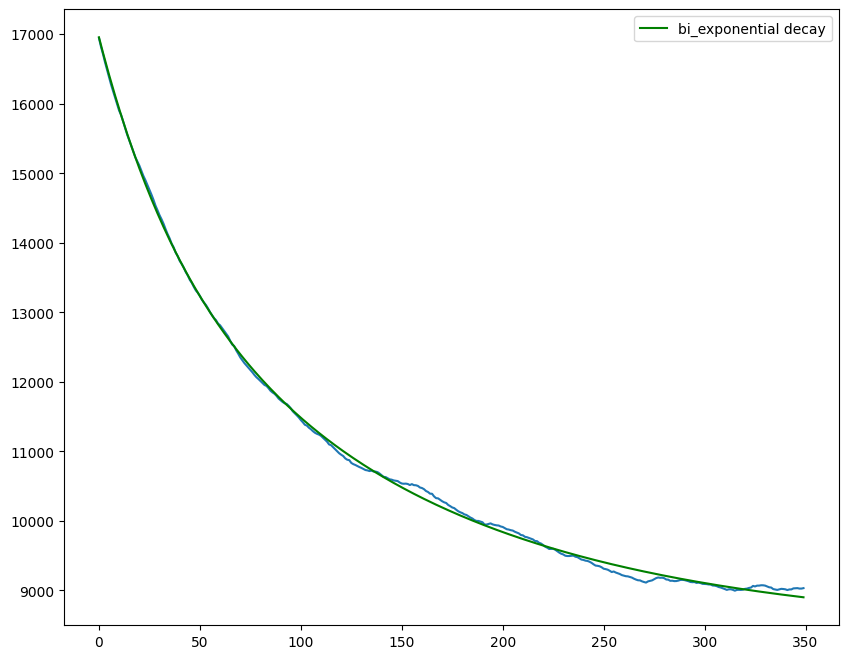

In [258]:
# CALCULATE AVERAGE (BI)EXPONENTIAL DECAY

average_trace = data.mean(axis=(1, 2))

r_squared_biexp = None
r_squared_exp = None

try:
    average_biexp_decay = get_bi_exponential_decay(average_trace)
    average_fitted_curve_biexp, average_popts_biexp, r_squared_biexp = (
        average_biexp_decay
    )
    ave_lbl = "bi_exponential decay"
except Exception as e:
    average_biexp_decay = None
    print(f"Error fitting bi-exponential curve: {e}")

try:
    average_exp_decay = get_exponential_decay(average_trace)
    average_fitted_curve_exp, average_popts_exp, r_squared_exp = average_exp_decay
    ave_lbl = "exponential decay"
except Exception as e:
    average_exp_decay = None
    print(f"Error fitting exponential curve: {e}")

if average_popts_biexp is None and average_popts_exp is None:
    average_fitted_curve = None
    average_popts = None
    average_r_squared = None
    average_offset = None
    msg = "No curve was fitted."

elif average_popts_biexp is None and average_popts_exp is not None:
    average_fitted_curve = average_fitted_curve_exp
    average_popts = average_popts_exp
    average_r_squared = r_squared_exp
    average_offset = average_popts[2]
    ave_lbl = "exponential decay"
    msg = f"Only exponential curve was fitted with R squared: {r_squared_exp}"

elif average_popts_biexp is not None and average_popts_exp is None:
    average_fitted_curve = average_fitted_curve_biexp
    average_popts = average_popts_biexp
    average_r_squared = r_squared_biexp
    average_offset = average_popts[4]
    ave_lbl = "bi_exponential decay"
    msg = f"Only bi-exponential curve was fitted with R squared: {r_squared_biexp}"

elif average_popts_biexp is not None and average_popts_exp is not None:
    if r_squared_biexp > r_squared_exp:
        average_fitted_curve = average_fitted_curve_biexp
        average_popts = average_popts_biexp
        average_r_squared = r_squared_biexp
        average_offset = average_popts[4]
        ave_lbl = "bi_exponential decay"
    else:
        average_fitted_curve = average_fitted_curve_exp
        average_popts = average_popts_exp
        average_r_squared = r_squared_exp
        average_offset = average_popts[2]
        ave_lbl = "exponential decay"
    msg = (
        f"Both curves were fitted. The best curve was chosen: {ave_lbl} "
        f"with R squared: {average_r_squared}"
    )

print(msg)

plt.figure(figsize=(10, 8))
plt.plot(average_trace)
plt.plot(average_fitted_curve, "green", label=ave_lbl)
plt.legend()
plt.show()

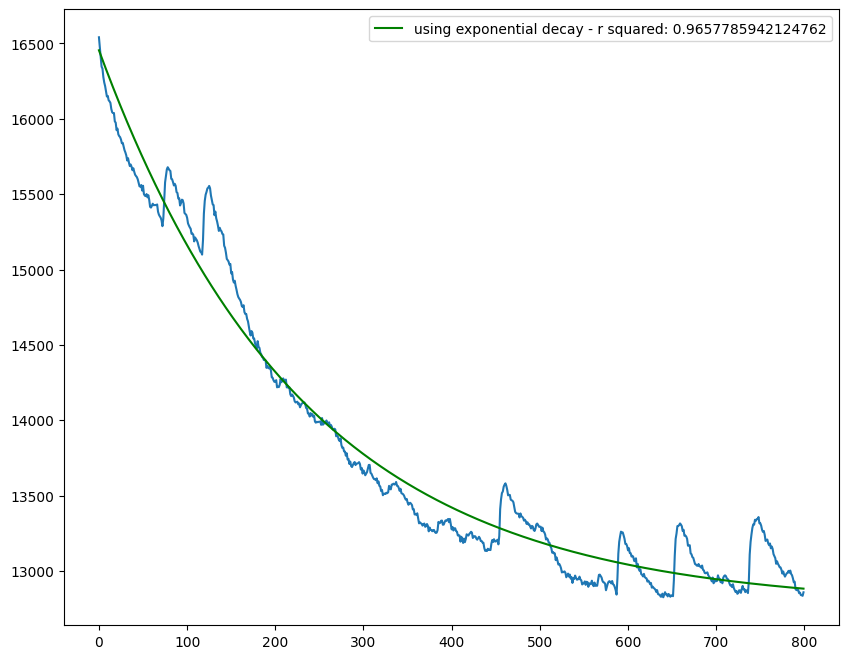

In [214]:
# CALCULATE (BI)EXPONENTIAL DECAY FOR EACH ROI. USE AVERAGE IF ROI FIT FAILS.

ROI = 53

mask = labels == ROI
masked_data = data[:, mask]

roi_trace = masked_data.mean(axis=1)

r_squared_biexp = None
r_squared_exp = None

try:
    biexp_decay = get_bi_exponential_decay(roi_trace)
    fitted_curve_biexp, popts_biexp, r_squared_biexp = biexp_decay
except Exception as e:
    biexp_decay = None
    print(f"Error fitting bi-exponential curve: {e}")

try:
    exp_decay = get_exponential_decay(roi_trace)
    fitted_curve_exp, popts_exp, r_squared_exp = exp_decay
except Exception as e:
    exp_decay = None
    print(f"Error fitting exponential curve: {e}")

if biexp_decay is None and exp_decay is None:
    if average_fitted_curve is None:
        raise ValueError("No curve was fitted.")

    fitted_curve = average_fitted_curve
    popts = average_popts
    r_squared = average_r_squared
    offset = average_offset
    lbl = "using average curve"

elif biexp_decay is not None and exp_decay is None:
    fitted_curve = fitted_curve_biexp
    popts = popts_biexp
    r_squared = r_squared_biexp
    offset = popts[4]
    lbl = "using bi_exponential decay"

elif biexp_decay is None and exp_decay is not None:
    fitted_curve = fitted_curve_exp
    popts = popts_exp
    r_squared = r_squared_exp
    offset = popts[2]
    lbl = "using exponential decay"

elif biexp_decay is not None and exp_decay is not None:
    if r_squared_biexp > r_squared_exp:
        fitted_curve = fitted_curve_biexp
        popts = popts_biexp
        r_squared = r_squared_biexp
        offset = popts[4]
        lbl = "using bi_exponential decay"
    else:
        fitted_curve = fitted_curve_exp
        popts = popts_exp
        r_squared = r_squared_exp
        offset = popts[2]
        lbl = "using exponential decay"


plt.figure(figsize=(10, 8))
plt.plot(roi_trace)
plt.plot(fitted_curve, "green", label=f"{lbl} - r squared: {r_squared}")
plt.legend()
plt.show()

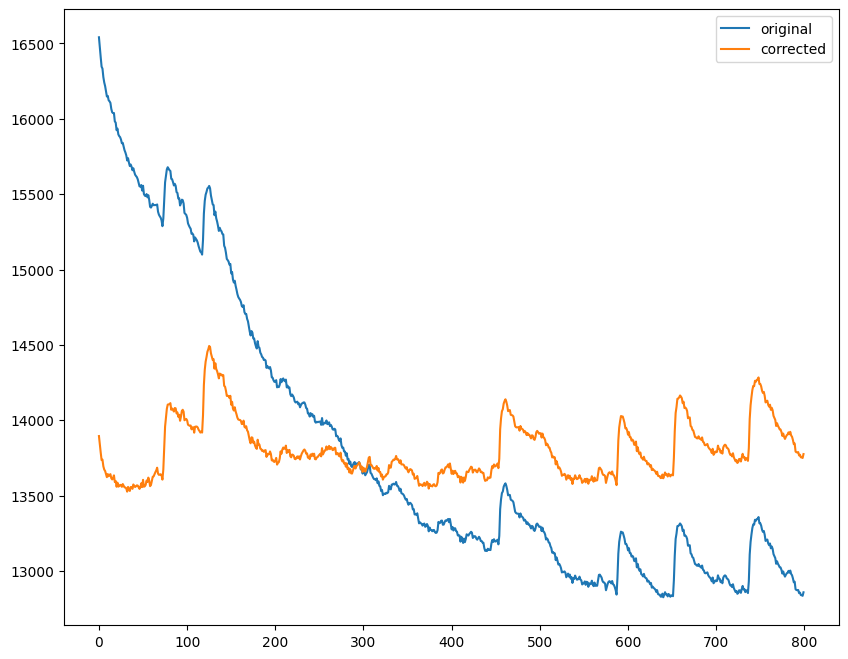

In [215]:
# CORRECT PHOTOBLEACHING USING FITTED CURVE

bleach_corrected = correct_photobleaching(roi_trace, fitted_curve, offset)

plt.figure(figsize=(10, 8))
plt.plot(roi_trace, label="original")
plt.plot(bleach_corrected, label="corrected")
plt.legend()
plt.show()

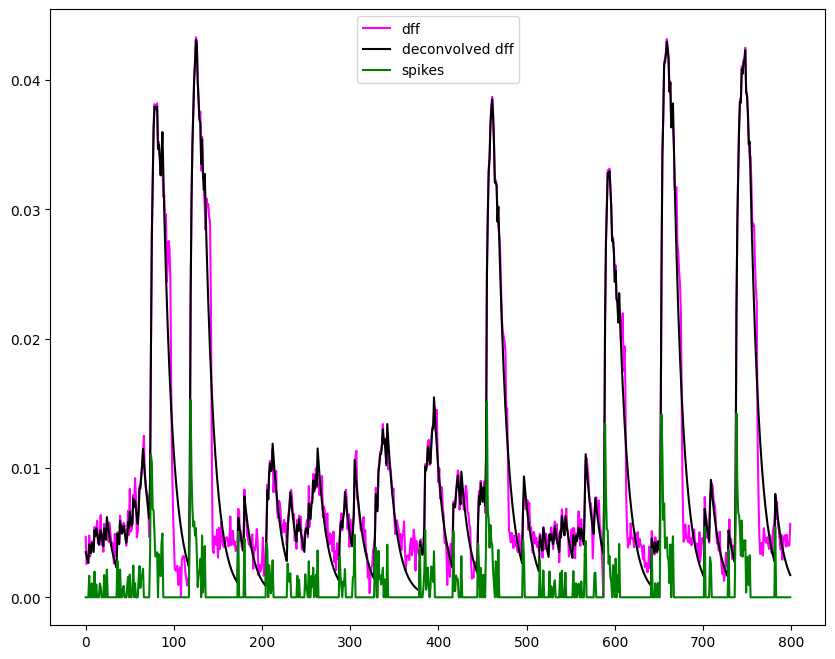

In [216]:
# CALCULATE DELATA F OVER F

dff = calculate_dff(bleach_corrected, window=50, plot=False)

# normalize dff between 0 and 1
# dff = (dff - np.min(dff)) / (np.max(dff) - np.min(dff))

# DECONVOLVE DFF

dec_dff, pk, _, k, _ = deconvolve(dff, penalty=1)
# dec_dff, pk, _, k, _ = deconvolve(dff, g=(None, None), penalty=1)
# dec_dff, pk, _, k, _ = deconvolve(dff, g=(0.95,), penalty=1)
# dec_dff, pk, _, k, _ = deconvolve(dff, g=(1.2, -0.3), penalty=1)
plt.figure(figsize=(10, 8))
plt.plot(dff, label="dff", color="magenta")
plt.plot(dec_dff, label="deconvolved dff", color="black")
plt.plot(pk, label="spikes", color="green")
plt.legend()
plt.show()

Number of peaks: 110

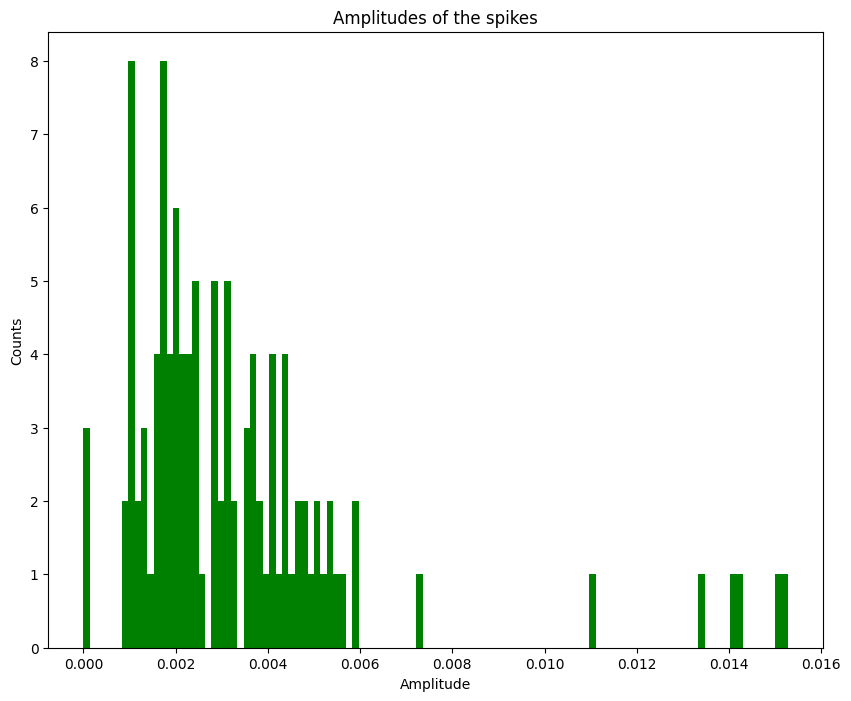

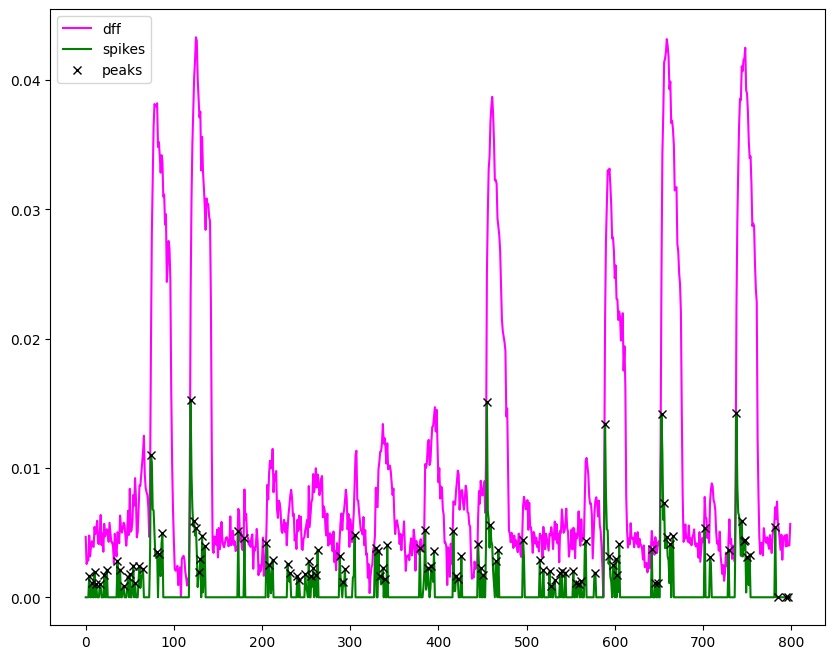

In [229]:
# FIND PEAKS

# normalize pk between 0 and 1
# pk = (pk - np.min(pk)) / (np.max(pk) - np.min(pk))

# prominence = np.max(pk) * 0.2 # 10% of the maximum value
# pks, _ = find_peaks(pk, prominence=prominence)
pks, _ = find_peaks(pk)
print(f"Number of peaks: {len(pks)}")

# Get the amplitudes of the spikes
amplitudes = pk[pks]
plt.figure(figsize=(10, 8))
plt.title("Amplitudes of the spikes")
plt.ylabel("Counts")
plt.xlabel("Amplitude")
plt.hist(amplitudes, bins=len(amplitudes), color="green")
plt.show()


plt.figure(figsize=(10, 8))
plt.plot(dff, label="dff", color="magenta")
plt.plot(pk, label="spikes", color="green")
plt.plot(pks, pk[pks], "kx", label="peaks")
plt.legend()
plt.show()


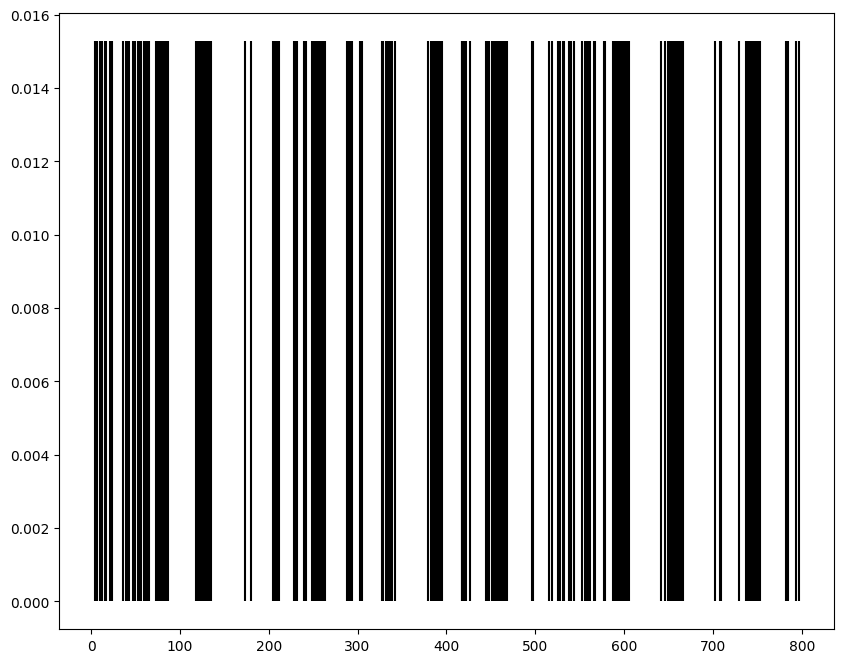

In [230]:
# RASTER PLOT

plt.figure(figsize=(10, 8))
plt.vlines(np.where(pk > 0)[0], ymin=0, ymax=pk.max(), color='black', label='Inferred Spikes')
plt.show()

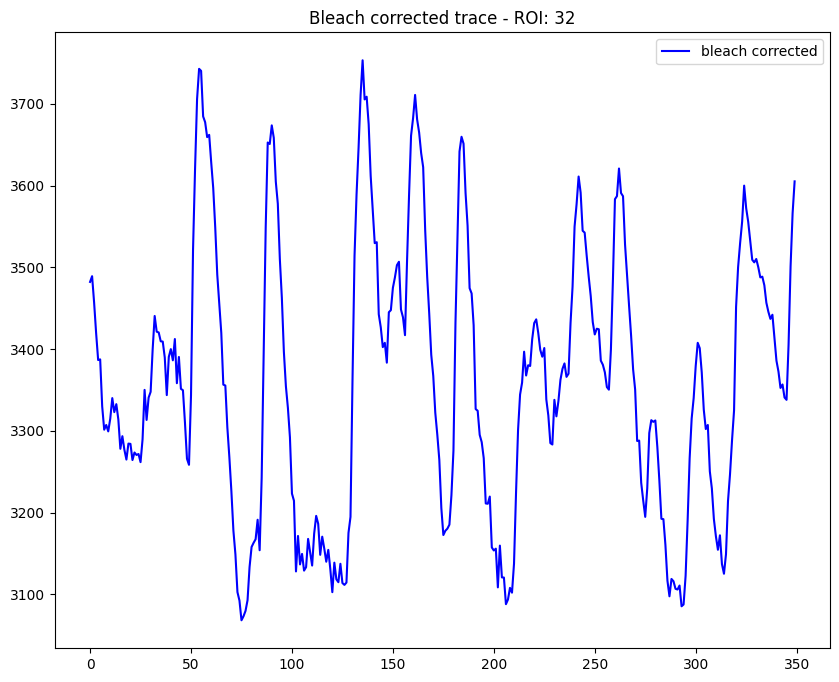

In [152]:
# CORRECT PHOTOBLEACHING USING FITTED CURVE

bleach_corrected = roi_trace - fitted_curve + popts[2]

plt.figure(figsize=(10, 8))
plt.title(f"Bleach corrected trace - ROI: {ROI}")
# plt.plot(roi_trace, "green", label="raw trace")
plt.plot(bleach_corrected, "blue", label="bleach corrected")
plt.legend()
plt.show()

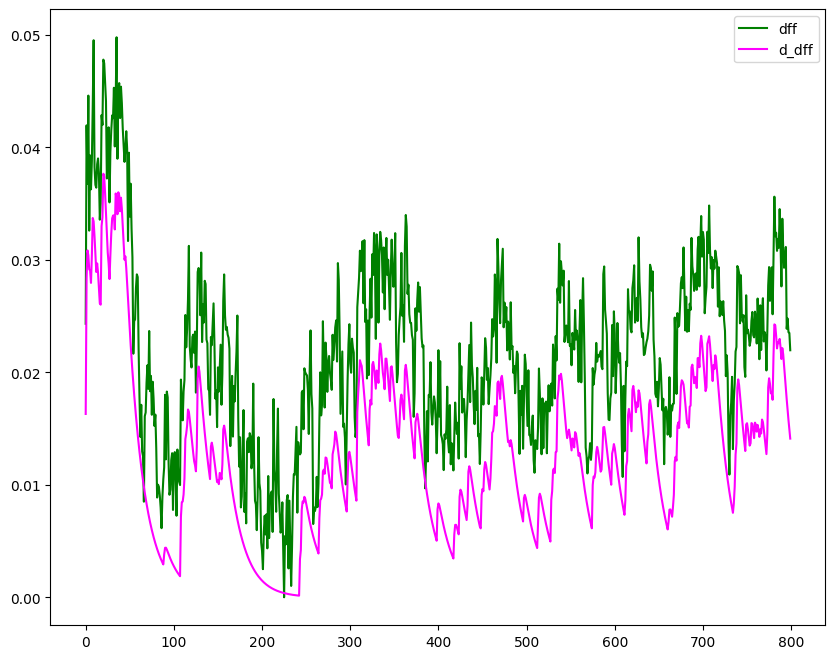

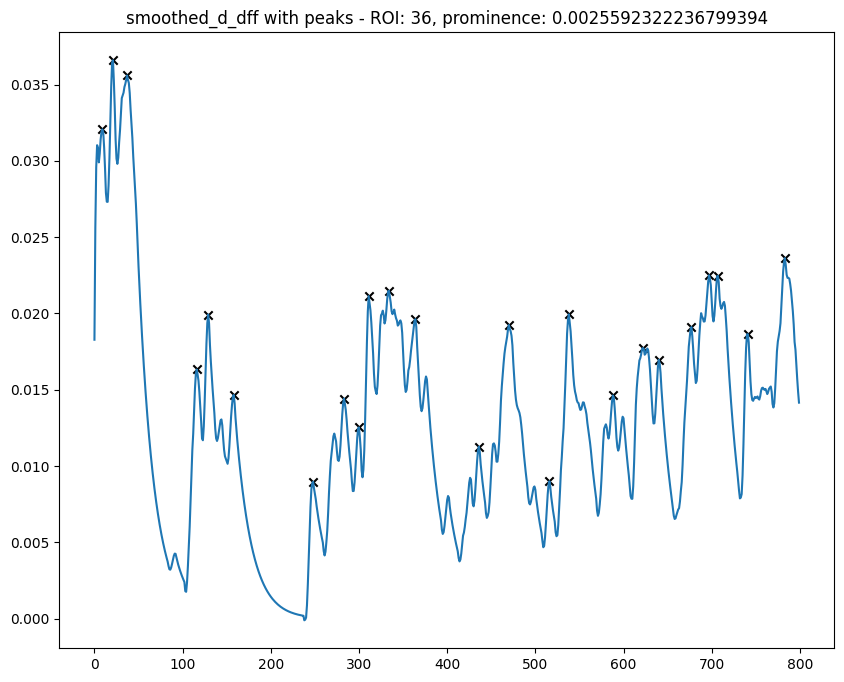

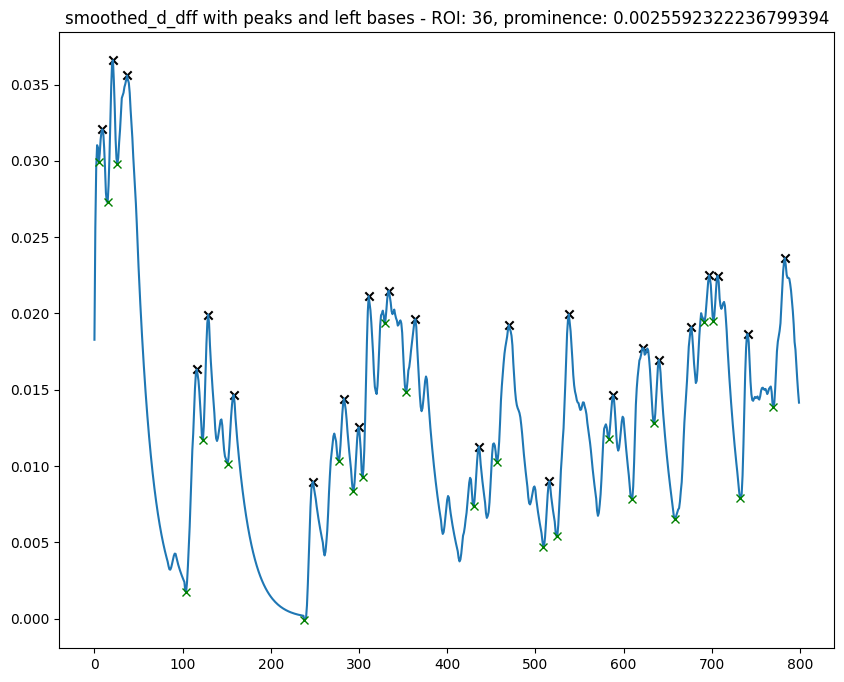

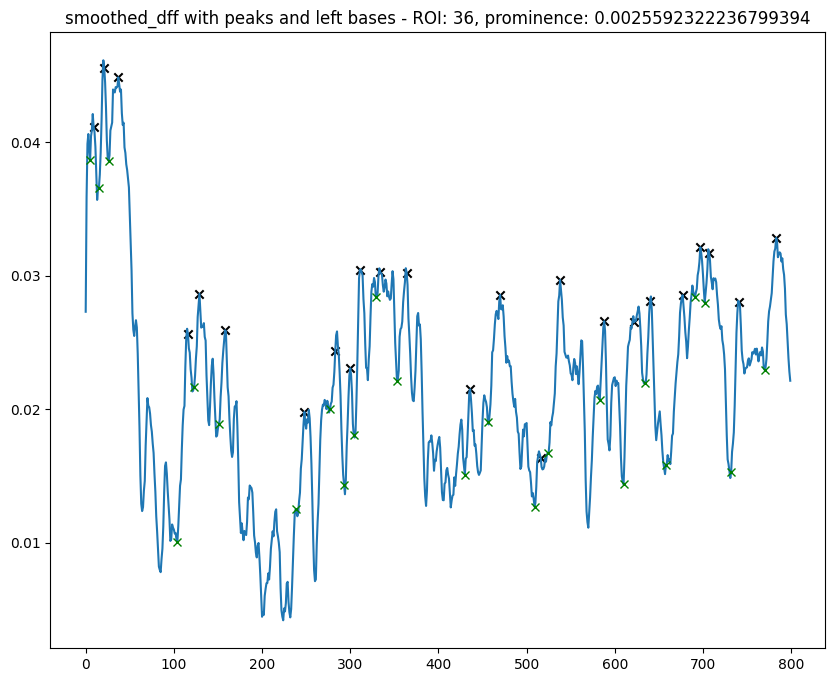

In [261]:
dff = calculate_dff(bleach_corrected, window=50, plot=False)
# plt.figure(figsize=(10, 8))
# plt.plot(dff, 'green')
# plt.show()

d_dff, _, _, _, _ = deconvolve(dff, g=(None, None), penalty=1)
plt.figure(figsize=(10, 8))
plt.plot(dff, "green", label="dff")
plt.plot(d_dff, "magenta", label="d_dff")
plt.legend()
plt.show()

prominence = np.mean(d_dff) * 0.2  # 20% of the mean value
smoothed_d_dff = savgol_filter(d_dff, window_length=10, polyorder=3)
peaks, peaks_props = find_peaks(smoothed_d_dff, width=3, prominence=prominence)

dff_plot = smoothed_d_dff
plt.figure(figsize=(10, 8))
plt.title(f"smoothed_d_dff with peaks - ROI: {ROI}, prominence: {prominence}")
plt.plot(dff_plot)
plt.scatter(peaks, dff_plot[peaks], color="black", marker="x")
# plt.plot(peaks_props["left_bases"], dff_plot[peaks_props["left_bases"]], "gx")
# plt.plot(peaks_props["right_bases"], dff_plot[peaks_props["right_bases"]], "mx")
plt.show()

lb = assign_left_bases(dff_plot, peaks, peaks_props["left_bases"])
plt.figure(figsize=(10, 8))
plt.title(
    f"smoothed_d_dff with peaks and left bases - ROI: {ROI}, prominence: {prominence}"
)
plt.plot(dff_plot)
plt.scatter(peaks, dff_plot[peaks], color="black", marker="x")
plt.plot(lb, dff_plot[lb], "gx")
plt.show()


smoothed_dff = savgol_filter(dff, window_length=10, polyorder=3)
dff_plot = smoothed_dff
plt.figure(figsize=(10, 8))
plt.title(
    f"smoothed_dff with peaks and left bases - ROI: {ROI}, prominence: {prominence}"
)
# plt.plot(dff)
plt.plot(dff_plot)
plt.scatter(peaks, dff_plot[peaks], color="black", marker="x")
plt.plot(lb, dff_plot[lb], "gx")
plt.show()
